### Вариант №2

Я взял экспрессив **ever**.
Это экспрессив, потому что:

1. Independence – главная цель употребляется не дескрипция, так как описать некоторое явление можно без **ever**: "That's the worst song I've heard." vs "That's the worst song I've ever heard."
2. Descriptive ineffability – обычного дескриптивного контекста бывает недостаточно: "He was the best boxer in the history. The best **ever**!"
3. Repeatability – "This the best gift I've ever gotten, **ever**!"

Моя гипотеза – U-образный профиль данного экспрессива, так как обычно **ever** употребляется в восклицательных контекстах, который могут быть как положительными (*the best party ever!*), так и отрицательными (*this is the worst day in my life ever!*).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk import word_tokenize

In [2]:
df = pd.read_json("Video_Games_5.json", lines=True) # amazon review https://nijianmo.github.io/amazon/index.html

In [3]:
df = df.loc[:30000, ["overall", "reviewText"]]
df = df[df['reviewText'].apply(lambda x: isinstance(x, str))] # так как датасет нечистый
df.head()

,overall,reviewText
0,5,"This game is a bit hard to get the hang of, bu..."
1,4,I played it a while but it was alright. The st...
2,3,ok game.
3,2,"found the game a bit too complicated, not what..."
4,5,"great game, I love it and have played it since..."


Распределение оценок в основном корпусе:

In [4]:
df["overall"].value_counts()

5    18525
4     6047
3     2860
2     1310
1     1255
Name: overall, dtype: int64

In [5]:
df["words"] = df["reviewText"].str.lower().apply(word_tokenize)

Распределение оценок в подкорпусе:

In [7]:
my_word = "ever"
mask = df.words.apply(lambda x: my_word in x)
new_df = df[mask]
new_df["overall"].value_counts()

5    3044
4     739
3     290
1     199
2     187
Name: overall, dtype: int64

In [13]:
new_df.to_csv("new_corpus.tsv", sep="\t")

Считаем длины слов:

In [9]:
def count_words_of_nlength(words, length):
    count = 0
    for word in words:
        if len(word) == length:
            count += 1
    return count

df["count_n"] = 0
for i in range(df.shape[0]):
    df["count_n"].iloc[i] = count_words_of_nlength(df["words"].iloc[i], len(my_word))

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Считаем метрику log_odds(xn, R):

In [10]:
log_odds_dict = {}
for i in range(1, 6):
    count_xn_R = new_df["overall"].value_counts().loc[i]
    count_R = df[(df["count_n"] > 0) & (df["overall"] == i)]["count_n"].sum()
    log_odds = np.log(count_xn_R / (count_R - count_xn_R))
    print(f"{i}. count_xn_R: {count_xn_R}, count_R: {count_R}")
    log_odds_dict[i] = log_odds
    
x = np.array(list(log_odds_dict.keys()))
y = np.array(list(log_odds_dict.values()))

1. count_xn_R: 199, count_R: 37520
2. count_xn_R: 187, count_R: 57388
3. count_xn_R: 290, count_R: 124007
4. count_xn_R: 739, count_R: 256813
5. count_xn_R: 3044, count_R: 560203


Строим график:

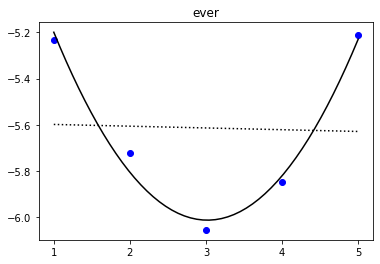

In [11]:
def build_graph(x, y, title):
    fig, ax = plt.subplots()
    lin = np.polyfit(x, y, 1) # linear model
    quadr_model = np.poly1d(np.polyfit(x, y, 2)) # quadratic model
    myline = np.linspace(x.min(), x.max(), 50)
    ax.scatter(x, y, color="b")
    ax.plot(x, lin[0]*x + lin[1], "k:") # linear model
    ax.plot(myline, quadr_model(myline), "k") # quadratic model
    plt.xticks(np.arange(x.min(), x.max() + 1))
    plt.title(title)
    plt.show()
    
build_graph(x, y, my_word)

Видно, что квадратичная регрессия наилучшим образом описывает данные.

### Выводы

Видно, что первоначальная гипотеза об U-образном профиле потдвердилась. Посмотрим на несколько коротких отзывов:

In [14]:
short_df = new_df[new_df["words"].apply(lambda x: len(x) < 70)]

Рейтинг 1:

In [15]:
print(short_df[short_df["overall"] == 1]["reviewText"].iloc[0] + "\n\n" +
      short_df[short_df["overall"] == 1]["reviewText"].iloc[1])

this game is the hardest game ive ever played, and that takes away the fun. also graphics very poor even for nintendo 64 cannot even recommend for people i dislike don't waste your time or money worst n64 game ever

this is the stuppidiest game i've ever played. I advise everyone not to play it or buy it. It really sucked.


Рейтинг 5:

In [16]:
print(short_df[short_df["overall"] == 5]["reviewText"].iloc[3] + "\n\n" +
      short_df[short_df["overall"] == 5]["reviewText"].iloc[4])

all i can say is that this game is a classic, possibly the best game ever made for the playstation 1.

star wars rogue squadron is hands down the best n64 game ever made get this game even if you're not a star wars fan you won't regret it


В примерах с рейтингом 1,5, как и ожидалось, экспрессивные и эмоциональные контексты (сугубо положительные/отрицательные).

Рейтинг 2-3:

В отзывах с рейтингом 2-3 присутствуют компоненты как отрицательные, так и положительные (причем есть и экспрессивные примеры)

In [17]:
short_df[short_df["overall"] == 2]["reviewText"].iloc[1]

"THE GRAPHICS AREN'T TOO GOOD, THE CARS LOOK GREAT BUT ARE LOADED WITH MORE HANDLING PROBLEMS THAN EVER BEFORE, AND THE GAMEPLAY SUCKS. LET'S FACE IT, THE ONCE-GREAT RIDGE RACER SERIES IS NOW DEAD. AND THIS IS THE GAME THAT HELPED SEAL ITS FATE."

In [18]:
short_df[short_df["overall"] == 2]["reviewText"].iloc[3]

"I found this game very boring and stupid. It does have the best classic games ever made on it. but i didn't find them that enjoyable, but centapide was fun the best on there. All in all it was okay i wouldn't buy it."

In [19]:
short_df[short_df["overall"] == 3]["reviewText"].iloc[0]

'I like all of the ff\'s but this is the worst ever!! I do like this game and the love story is great but no matter how hard you try when you get on disc 4 and beat the game all you can say is "wow...now wheres my ff7 disc?" get ff9 before this one...'

In [20]:
short_df[short_df["overall"] == 3]["reviewText"].iloc[1]

'When I purchased the N64 version I was disappointed that it required an expansion pak to play it. Now I have to wait a few more days for those to arrive to play one of the best games ever made.\n\nUPDATE: not the game I thought it was. Donkey Kong COUNTRY is the version I remember as a child.'

Неожиданные случаи:

Несколько просмотренных примеров с оценкой 4 выглядят сугубо положительными, без каких-либо негативных элементов (возможно, это специфика авторов отзывов – ставить 5 в самых крайних случаях):

In [21]:
print(short_df[short_df["overall"] == 4]["reviewText"].iloc[1] + "\n\n" +
      short_df[short_df["overall"] == 4]["reviewText"].iloc[3] + "\n\n" +
      short_df[short_df["overall"] == 4]["reviewText"].iloc[4])

Best Mario ever made!!!

Great n64 game played it when I was little kid one of the best n64 games ever made next to Mario 64 and 007 golden eye

Thanks again for this I have been a pokemon fanatic ever since I was a kid. I couldn't ask for more thanks again.


Примеры, которые не должны были попасть в корпус:

In [22]:
print(short_df[short_df["overall"] == 2]["reviewText"].iloc[2] + "\n\n" +
      short_df[short_df["overall"] == 4]["reviewText"].iloc[0])

I would rent this game. It takes no skills what so ever to beat it. Maybe it just came naturally to me, or maybe I'm just to critical but this game is not worth buying. In my opinion this game would only appeal the the 8-11 age range and even then would they only play it once or twice.

The only down side is that these guides are not from Nintendo, so there's very little original art work and a lot of information. How ever the hardcover and golden side shets make it an elegant product.


В данных примерах имелись в виду слова *whatsoever* и *however*. Подобные примеры говорят нам о том, что для более точных выводов необходимо более детальное погружение в корпусные данные.